##### Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from collections import Counter
from operator import itemgetter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline


from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#load in the attributes data 

dias_attr = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
dias_in = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')

In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
print("Germany General Population", azdias.shape)
print("Mail Order Customers", customers.shape)

Germany General Population (891221, 366)
Mail Order Customers (191652, 369)


In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [7]:
dias_attr.drop(columns = ['Unnamed: 0'], inplace = True)
#dias_attr['Attribute'] = dias_attr['Attribute'].ffill()
#dias_attr['Description'] = dias_attr['Description'].ffill()
dias_attr.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [8]:
dias_in.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [9]:
dias_in_list = list(dias_attr['Attribute'].unique())
dias_attr_list = list(dias_attr['Attribute'].unique())
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)

print('Number of Information Levels Attributes:', len(dias_in_list))
print('Number of Attribute values:', len(dias_attr_list))
print('Number of Columns in demographic dataframe:', len(azdias_list))
print('Number of Columns in Customers dataframe:', len(customers_list))

Number of Information Levels Attributes: 315
Number of Attribute values: 315
Number of Columns in demographic dataframe: 366
Number of Columns in Customers dataframe: 369


In [10]:
missing_feats =list(set(azdias.columns.values).difference(dias_attr_list))
print('Number of Attributes In the attributes dataset but missing in the data', len(missing_feats))

Number of Attributes In the attributes dataset but missing in the data 94


In [11]:
missing_feats.remove('LNR')

In [12]:
pickle.dump(missing_feats, open("missing_feats.pkl", "wb"))

In [13]:
cus_cols = list(set(customers_list) - set(azdias_list))
print("Number of columns in customers dataframe and not in demographic dataframe",cus_cols)
pickle.dump(cus_cols, open("cus_cols.pkl", "wb"))

Number of columns in customers dataframe and not in demographic dataframe ['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']


Customers dataframe has three more columns than the demographic dataframe. We we drop these columns from the analysis

In [14]:
customers = customers.drop(cus_cols, axis = 1)

In [15]:
azdias = azdias.drop(missing_feats, axis = 1)


In [16]:
customers = customers.drop(missing_feats, axis = 1)

In [17]:
print('Number of features in demographics dataset', len(azdias.columns))

Number of features in demographics dataset 273


### Preprocessing

###### 1. Missing Values
- Some of the variables indicate -1 or 0 when a value is missing. We need to transform this to indicate missing values
- Investigate the proportion of missing values in each of the variables and each of the rows to determine which rows/variables to drop and which to impute

In [18]:
natural_missing_data = azdias.isnull().sum().sum()
print("Natural Missing Data before mapping : {}".format(natural_missing_data))


Natural Missing Data before mapping : 24071548


In [19]:
#Identify which values represent missing values and convert them to nan;s
na_list=dias_attr.loc[dias_attr['Meaning'] == 'unknown']
na_values = dict(zip(na_list['Attribute'], na_list['Value']))
    

for key, value in na_values.items():
    na_values[key] = list(str(value).replace(' ', '').split(','))

for col in range(azdias.shape[1]):
    col_name = azdias.columns[col]
    for k, v in na_values.items():
        if ((azdias[col_name].dtype =='object') and (col_name == k)):
            azdias[k] = np.where(azdias[k].isin(v), np.nan, azdias[k])

        elif((azdias[col_name].dtype !='object') and (col_name == k)):
            new_v = list(map(int,v))
            azdias[k] = np.where(azdias[k].isin(new_v), np.nan, azdias[k])
        

In [20]:
#Missing data after conversion
natural_missing_data = azdias.isnull().sum().sum()
print("Missing Data after mapping : {}".format(natural_missing_data))


Missing Data after mapping : 27414424


In [21]:
#Proportion of missing values in each column
missing_vals = azdias.isnull().mean()

missing_vals.sort_values(inplace=True, ascending=False)

#Visualise columns with more than 25% of their values missing


Text(0.5,0,'Percentage of Missing Values')

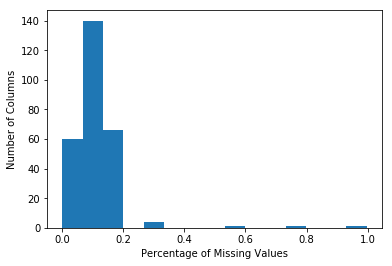

In [22]:
plt.hist(missing_vals, bins=15);
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')


In [23]:
missing_vals = missing_vals[missing_vals > 0.25]

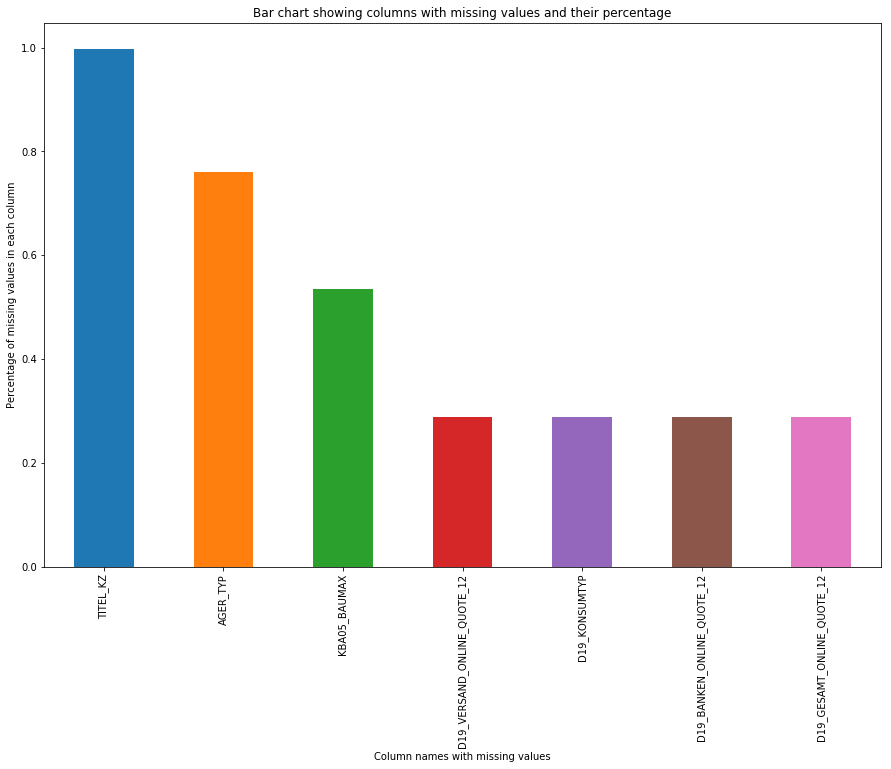

In [24]:
# visualising percentage bar chart of missing columns values
missing_vals.plot.bar(figsize=(15,10))
plt.xlabel('Column names with missing values')
plt.ylabel('Percentage of missing values in each column')
plt.title('Bar chart showing columns with missing values and their percentage')
plt.show()


In [25]:
len(missing_vals)

7

In [26]:
missing_vals

TITEL_KZ                       0.997576
AGER_TYP                       0.760196
KBA05_BAUMAX                   0.534687
D19_VERSAND_ONLINE_QUOTE_12    0.288495
D19_KONSUMTYP                  0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
dtype: float64

Nineteen columns have more than 25% of their values missing. We will drop these columns from the analysis. Most of the columns that are to be dropped begin with D19 - which has a lot to do with transaction activity

In [27]:

mcv_greater_30 =[]
for col in azdias.columns:
    if (azdias[col].isnull().sum()/azdias.shape[0]) * 100 > 25:
        mcv_greater_30.append(col)
        
pickle.dump(mcv_greater_30, open("mcv_greater_30.pkl", "wb"))


In [28]:

# Removing column with more than 30 percent missing data
azdias = azdias.drop(mcv_greater_30,axis=1)
azdias.head()

print(f'{len(mcv_greater_30)} columns greater than 30% in missing column values were dropped')
print(f'{azdias.shape[1]} columns are remaining')

azdias.columns

7 columns greater than 30% in missing column values were dropped
266 columns are remaining


Index(['LNR', 'ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015', 'CJT_GESAMTTYP',
       ...
       'SEMIO_TRADV', 'SEMIO_VERT', 'SHOPPER_TYP', 'VERS_TYP',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=266)

In [29]:
# How much data is missing in each row of the dataset?
check_missing_row_values = azdias.isnull().sum(axis=1)
missing_row_values = check_missing_row_values[check_missing_row_values > 0]
missing_row_values.sort_values(inplace=True, ascending=False)


# calculating the percent of missing values in a row
mrv_percent=missing_row_values.sort_values()/azdias.shape[1] * 100


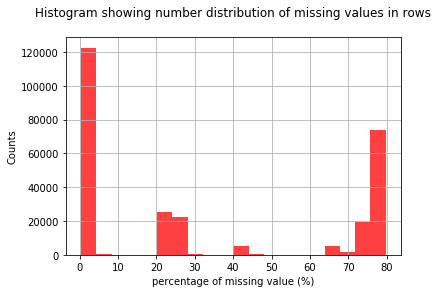

In [30]:
plt.hist(mrv_percent, bins=20, facecolor='r', alpha=0.75)
plt.xlabel('percentage of missing value (%)')
plt.ylabel('Counts')
plt.title('Histogram showing number distribution of missing values in rows\n')
plt.grid(True)
plt.show()

In [31]:
#drop rows with many missing values 
azdias = azdias[azdias.isnull().sum(axis=1) <= 20].reset_index(drop=True)
print('number of rows in new dataset: ',azdias.shape[0])


number of rows in new dataset:  737287


### Encoding Features

In [32]:
categorical_cols = list(azdias.select_dtypes(include=['object', 'category']).columns)
categorical_cols
#variables that are marked as categorical in the dataframe

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ']

In [33]:
#there are other variables based on the description that could be categorical
pos_categorical = ('ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'VERS_TYP')


In [34]:
categorical_cols.extend(pos_categorical)
categorical_cols


['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'OST_WEST_KZ',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GEBAEUDETYP_RASTER',
 'GFK_URLAUBERTYP',
 'HEALTH_TYP',
 'KBA05_HERSTTEMP',
 'KBA05_MAXHERST',
 'KBA05_MODTEMP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'SHOPPER_TYP',
 'VERS_TYP']

In [35]:
for i in categorical_cols:
    print(azdias[i].value_counts())

6B    54006
8A    50776
4C    43988
2D    32906
7A    32629
3C    32565
3D    32176
8B    31262
4A    30254
8C    30147
9D    26746
9B    25888
7B    22921
9C    22919
9A    20057
2C    17742
8D    16675
6E    15598
5D    14071
2B    14042
6C    13868
2A    11921
1D    11457
1A    10167
5A     9721
5B     9691
5C     9050
4B     8284
7C     8127
4D     8051
6A     6416
3A     5871
6D     5756
3B     5709
6F     5048
4E     5005
1E     4783
7D     4431
7E     4375
1C     4012
5F     3939
9E     3841
1B     3815
5E     3241
XX      284
Name: CAMEO_DEU_2015, dtype: int64
8      74754
6      58203
9      57473
4      55290
8.0    54106
2      44419
3      44192
6.0    42489
9.0    41978
7      41861
4.0    40292
2.0    32192
3.0    32129
7.0    30622
5      28976
5.0    20737
1      19840
1.0    14394
X        284
Name: CAMEO_DEUG_2015, dtype: int64
W    582289
O    154998
Name: OST_WEST_KZ, dtype: int64
2.0    384279
1.0    353008
Name: ANREDE_KZ, dtype: int64
4.0    182291
3.0    135153


In [36]:
#Column Types
azdias['CAMEO_DEUG_2015'] = np.where(azdias['CAMEO_DEUG_2015'] == 'XX', np.nan,azdias['CAMEO_DEUG_2015'])


In [37]:
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].str.split('.').str[0]

In [38]:
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

In [39]:
#Delete all other categorical variables

cols_to_drop = ['CAMEO_DEU_2015']
     
azdias.drop(cols_to_drop, axis=1, inplace = True)


In [40]:
azdias.head()

,LNR,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,0.0,11.0,0.0,2.0,0.0,6.0,NaN,5.0,0,...,6.0,1.0,3.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0
1,910225,17.0,10.0,0.0,1.0,0.0,2.0,NaN,3.0,0,...,3.0,4.0,2.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0
2,910226,13.0,1.0,0.0,0.0,0.0,4.0,NaN,2.0,0,...,4.0,4.0,1.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0
3,910241,20.0,3.0,0.0,4.0,0.0,2.0,NaN,5.0,3,...,2.0,7.0,2.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0
4,910244,10.0,5.0,0.0,1.0,0.0,6.0,NaN,2.0,0,...,6.0,2.0,0.0,2.0,6.0,9.0,7.0,4.0,2.0,1.0


In [41]:
#change LNR to index
azdias.set_index('LNR', inplace = True)

In [42]:
new_azdias= azdias.copy()

In [43]:
azdias_df = pd.get_dummies(azdias)

In [44]:
azdias_df.shape

(737287, 273)

In [45]:
#Impute the missing variables in the demographic dataframe
imputer = Imputer()
azdias_clean = pd.DataFrame(imputer.fit_transform(azdias_df), columns = azdias_df.columns)

In [46]:
#pickle.dump(azdias_clean, open("azdias_clean.pickle", "wb"))

In [47]:
azdias_columns = list(azdias_clean.columns)
scale = StandardScaler(copy=False)
scaled = scale.fit_transform(azdias_clean)
azdias_scaled = pd.DataFrame(scaled,columns= azdias_columns)

In [48]:
def clean_data(df):
    
    na_list=dias_attr.loc[dias_attr['Meaning'] == 'unknown']
    na_values = dict(zip(na_list['Attribute'], na_list['Value']))
    for key, value in na_values.items():
        na_values[key] = list(str(value).replace(' ', '').split(','))
        
    for col in range(df.shape[1]):
        col_name = df.columns[col]
        for k, v in na_values.items():
            if ((df[col_name].dtype =='object') and (col_name == k)):
                df[k] = np.where(df[k].isin(v), np.nan, df[k])

            elif((df[col_name].dtype !='object') and (col_name == k)):
                new_v = list(map(int,v))
                df[k] = np.where(df[k].isin(new_v), np.nan, df[k])
                
    
    mcv_greater_30 = pickle.load(open("mcv_greater_30.pkl", "rb"))
    

    #Drop columns that have high number of missing values 
    df = df.drop(mcv_greater_30,axis=1)
    
    df['CAMEO_DEUG_2015'] = np.where(df['CAMEO_DEUG_2015'] == 'XX', np.nan,df['CAMEO_DEUG_2015'])

    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].str.split('.').str[0]

    cols_to_drop = ['CAMEO_DEU_2015','EINGEFUEGT_AM']
    for col in cols_to_drop:
        if col in df.columns:
            df.drop(col, axis=1, inplace = True)
        else:
            pass
    df.set_index('LNR',inplace=True)
    #drop rows that have many missing values across 
    df = pd.get_dummies(df)
    imputer = Imputer()
    df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
    
    df_columns = list(df.columns)
    scale = StandardScaler(copy=False)
    df_scaled = scale.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled,columns= df_columns)
    
    return df_scaled
        
    

In [49]:

customers_scaled = clean_data(customers)

In [50]:
customers_scaled.shape

(191652, 273)

In [51]:
pickle.dump(azdias_scaled, open("azdias_final.pickle", "wb"))
pickle.dump(customers_scaled, open("customers_final.pickle", "wb"))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
#load the pickle file after the analysis above
azdias_scaled = pickle.load(open("azdias_final.pickle", "rb"))
#load the pickle file after the analysis above
customers_scaled = pickle.load(open("customers_final.pickle", "rb"))

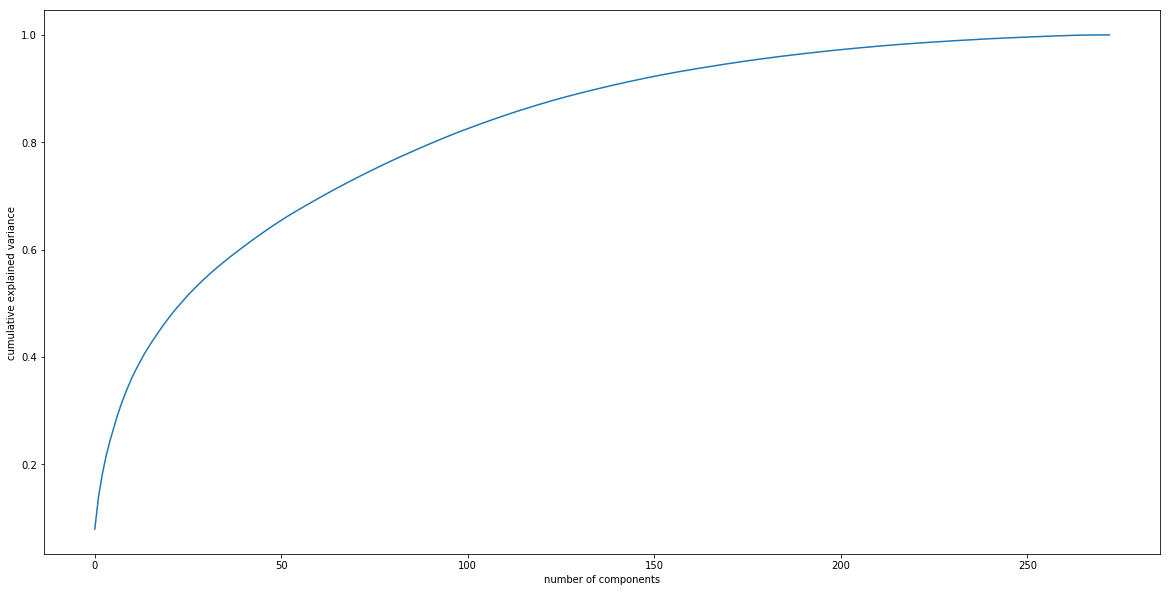

In [52]:
#Do PCA
pca = PCA().fit(azdias_scaled)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


Based on above chart we can see that at around 150 components, cumulative variance is still high that we do not lose critical information from the dimensions.

In [53]:

def reduce_data(df,n=150):
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data


In [54]:
reduced_azdias = reduce_data(azdias_scaled)

0.920580645057


In [55]:
reduced_customers = reduce_data(customers_scaled)

0.918602352713


In [56]:
# Map weights for the principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca = PCA(n_components=150).fit(azdias_scaled)

def print_interesting_features(features, components, i):
    feature_weights = dict(zip(features, components[i]))
    feature_weights_sorted = sorted(feature_weights.items(), key=lambda kv: kv[1])
    
    print('Highest:')
    for feature, weight in feature_weights_sorted[-3:]:
        print('{:20} {:.3f}'.format(feature, weight))
        
    print('Lowest:')
    for feature, weight in feature_weights_sorted[:3]:
        print('{:20} {:.3f}'.format(feature, weight))
    
        

In [57]:


# First principal component
i = 0
print_interesting_features(azdias_scaled.columns.values, pca.components_, i)



Highest:
KBA05_ANTG1          0.149
PLZ8_ANTG1           0.149
MOBI_REGIO           0.156
Lowest:
HH_EINKOMMEN_SCORE   -0.153
PLZ8_ANTG3           -0.145
PLZ8_ANTG4           -0.139


In [58]:
pca0 = ['KBA05_ANTG1','PLZ8_ANTG1','MOBI_REGIO','HH_EINKOMMEN_SCORE','PLZ8_ANTG3','PLZ8_ANTG4']
dias_attr[dias_attr['Attribute'].isin(pca0)]

,Attribute,Description,Value,Meaning
749,HH_EINKOMMEN_SCORE,estimated household net income,"-1, 0",unknown
795,KBA05_ANTG1,number of 1-2 family houses in the cell,-1,unknown
1987,MOBI_REGIO,moving patterns,1,very high mobility
2016,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,-1,unknown
2028,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-1,unknown
2033,PLZ8_ANTG4,number of >10 family houses in the PLZ8,-1,unknown


This component is an indicator of the relative family sizes and the household wealth. 

In [59]:

# First principal component
i = 1
print_interesting_features(azdias_scaled.columns.values, pca.components_, i)


Highest:
KBA13_BMW            0.153
KBA13_SEG_OBEREMITTELKLASSE 0.158
KBA13_HERST_BMW_BENZ 0.181
Lowest:
KBA13_SITZE_5        -0.143
KBA13_KMH_140_210    -0.131
KBA13_ALTERHALTER_60 -0.130


In [60]:
pca1 = ['KBA13_SITZE_5','KBA13_KMH_140_210','KBA13_ALTERHALTER_60','KBA13_BMW','KBA13_SEG_OBEREMITTELKLASSE','KBA13_HERST_BMW_BENZ']
dias_attr[dias_attr['Attribute'].isin(pca1)]

,Attribute,Description,Value,Meaning
1153,KBA13_ALTERHALTER_60,share of car owners between 46 and 60 within t...,-1,unknown
1224,KBA13_BMW,share of BMW within the PLZ8,-1,unknown
1441,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,-1,unknown
1497,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,-1,unknown
1761,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...,-1,unknown
1817,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-1,unknown


This component is an indicator of car ownership 

In [130]:

# First principal component
i = 2
print_interesting_features(azdias_scaled.columns.values, pca.components_, i)


Highest:
D19_GESAMT_ANZ_12    0.192
D19_GESAMT_ANZ_24    0.198
ONLINE_AFFINITAET    0.211
Lowest:
D19_GESAMT_ONLINE_DATUM -0.188
D19_GESAMT_DATUM     -0.181
D19_VERSAND_ONLINE_DATUM -0.180


In [131]:
pca2 = ['D19_GESAMT_ANZ_12','D19_GESAMT_ANZ_24','ONLINE_AFFINITAET','D19_GESAMT_ONLINE_DATUM','D19_GESAMT_DATUM','D19_VERSAND_ONLINE_DATUM']
dias_attr[dias_attr['Attribute'].isin(pca2)]

,Attribute,Description,Value,Meaning
305,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,0,no transactions known
312,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,0,no transactions known
319,D19_GESAMT_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months
339,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months
580,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months
1997,ONLINE_AFFINITAET,online affinity,0,none


This component is an indicator of transaction activity. 

In [129]:
i = 3
print_interesting_features(azdias_scaled.columns.values, pca.components_, i)


Highest:
D19_GESAMT_ANZ_12    0.126
D19_GESAMT_ANZ_24    0.128
ALTERSKATEGORIE_GROB 0.134
Lowest:
SEMIO_REL            -0.156
FINANZ_SPARER        -0.153
SEMIO_PFLICHT        -0.153


In [132]:
pca3 = ['D19_GESAMT_ANZ_12','D19_GESAMT_ANZ_24','ALTERSKATEGORIE_GROB','SEMIO_REL','FINANZ_SPARER','SEMIO_PFLICHT']
dias_attr[dias_attr['Attribute'].isin(pca3)]

,Attribute,Description,Value,Meaning
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
305,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,0,no transactions known
312,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,0,no transactions known
679,FINANZ_SPARER,financial typology: money saver,-1,unknown
2154,SEMIO_PFLICHT,affinity indicating in what way the person is ...,"-1, 9",unknown
2170,SEMIO_REL,affinity indicating in what way the person is ...,"-1, 9",unknown


This component is an indicator of transaction activity and customer age. It also indicates a persons religious stance, relatioship wiht money and mindset.

### Clustering

In [64]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))


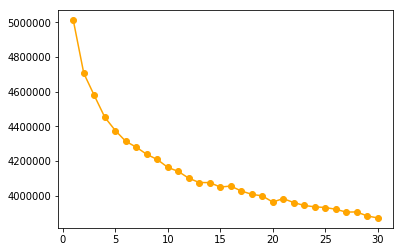

In [65]:
scores = []
for i in range(1, 31):
    scores.append(score(reduced_azdias.sample(20000), i))
centers = np.linspace(1,30,30)
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')

From above chart we can see that at around 15 clusters, average distance within cluster almost flattens and thus we will use 15 clusters

In [117]:
#Cluster the data using KMeans clustering with 15 clusters
kmeans_k = KMeans(10)
model_k = kmeans_k.fit(reduced_azdias)
pred_azdias = model_k.predict(reduced_azdias)

In [118]:
azdias_clustered = pd.DataFrame(pred_azdias, columns = ['Cluster'])
azdias_clustered.to_pickle('azdias_clustered.pkl')

In [119]:
pred_customers = model_k.predict(reduced_customers)
customer_clustered = pd.DataFrame(pred_customers, columns = ['Cluster'])
customer_clustered.to_pickle('customer_clustered.pkl')

#### Compare Customer Data to Demographics Data

In [120]:
cus_clusters = pd.Series(pred_customers)
demo_clusters = pd.Series(pred_azdias)

df = pd.concat([demo_clusters.value_counts().sort_index(), cus_clusters.value_counts().sort_index()], axis=1).reset_index()
df.columns = ['cluster','demographic','customer']

df['diff'] = (df['customer']/df['customer'].sum()*100) - (df['demographic']/df['demographic'].sum()*100)
df

,cluster,demographic,customer,diff
0,0,51233,7509,-3.030815
1,1,55620,19806,2.790482
2,2,96370,17865,-3.749311
3,3,88636,14149,-4.639261
4,4,106732,49541,11.373140
5,5,97867,27860,1.262829
6,6,71484,9808,-4.577937
7,7,76380,18952,-0.470845
8,8,36874,9732,0.076645
9,9,56091,16430,0.965073


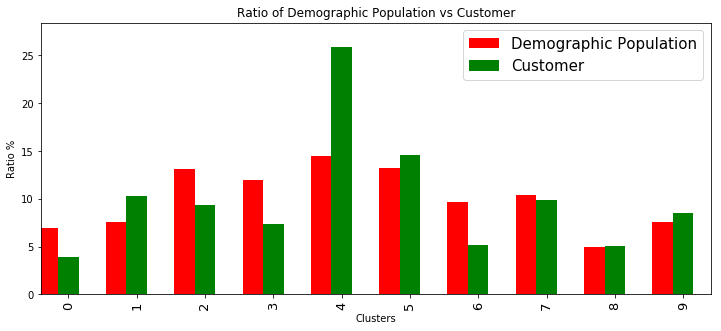

In [121]:

# Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.
df['demo_percent'] = (df['demographic']/df['demographic'].sum()*100).round(2)
df['cust_percent'] = (df['customer']/df['customer'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = df['demo_percent'].plot(x=df['cluster'],color='red',width=-0.3,kind='bar',align='edge',position=0)
ax = df['cust_percent'].plot(kind='bar',color='green',width=0.3,align='edge',position=1)
ax.set_xlabel('Clusters') 
ax.set_ylabel('Ratio %')
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Demographic Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Demographic Population vs Customer'))
plt.show()

Clusters that have over representation of the customer compared to general population - cluster 4
Cluster that has under representation of the customer compared to the general population is cluster 3

In [133]:

# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

weights_1 = model_k.cluster_centers_[4]
components_1 = list(range(0, 150))
cluster_components_1 = pd.DataFrame({'Weights': weights_1, 'Component': components_1})
cluster_components_1.sort_values('Weights',ascending=False)

,Weights,Component
0,3.338422,0
4,0.797305,4
5,0.520714,5
9,0.516728,9
19,0.317941,19
6,0.271823,6
25,0.174074,25
26,0.143014,26
52,0.124443,52
22,0.102114,22


Based on the clustering, indivduals who are overepresented in the customer's dataset are more likely to have high mobility and have a small family. In addition, these customers are also likely to be money saver, older and more religious

In [135]:

# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

weights_1 = model_k.cluster_centers_[3]
components_1 = list(range(0, 150))
cluster_components_1 = pd.DataFrame({'Weights': weights_1, 'Component': components_1})
cluster_components_1.sort_values('Weights',ascending=False)

,Weights,Component
0,5.240771,0
2,2.404124,2
4,1.023602,4
3,0.617708,3
9,0.304232,9
24,0.230587,24
42,0.136783,42
40,0.134405,40
13,0.128757,13
26,0.108037,26


For cluster 3, the most underrepresented cluster in the customer data. Customers in this cluster are unlikely to be customers of the mail order company. The high values relating to components 3 indicate that these individauls are likey to be younger and have low affinity to religion and saving money.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [86]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [87]:
mailout_train.shape

(42962, 367)

In [88]:

X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [89]:
train_X = X.copy()

In [90]:
train_X = clean_data(train_X)

In [91]:
#highly unbalanced dataset
y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [92]:
#Use Gradient Boosting Machine 
gbc = GradientBoostingClassifier()

param_grid = {'learning_rate': [0.01],
             'n_estimators': [100],
             'max_depth': [5]}

grid = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(train_X, y)
print(grid.best_score_)
print(grid.best_estimator_)


0.76310096265
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [93]:
pickle.dump(grid, open("gbm_model.pkl", "wb"))

### Feature Importance

['D19_SOZIALES' 'ANZ_KINDER' 'KBA13_KW_50' 'D19_RATGEBER'
 'LP_LEBENSPHASE_FEIN']
[ 0.25243815  0.03625089  0.03493889  0.02920844  0.02516371]


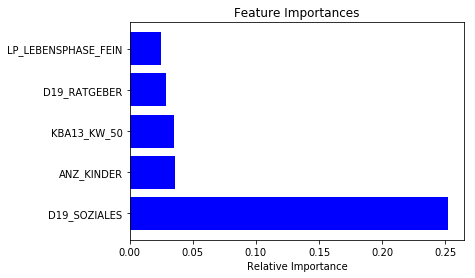

In [99]:
num_feat = 5

indices = np.argsort(grid.best_estimator_.feature_importances_)[::-1]
columns = train_X.columns.values[indices[:num_feat]]
values = grid.best_estimator_.feature_importances_[indices][:num_feat]

#print((indices))
print(columns)
print(values)

plt.title('Feature Importances')
plt.barh(np.arange(num_feat), values, color='b', align='center', label = "Feature Weight")
#plt.barh(np.arange(num_feat), np.cumsum(values), color='b', align='center',label = "Cumsum Weight")


plt.yticks(np.arange(num_feat), columns)
plt.xlabel('Relative Importance')
plt.show()


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [109]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [110]:
mailout_test.shape

(42833, 366)

In [111]:
mailout_test_new = mailout_test.copy()

In [113]:
mailout_test = clean_data(mailout_test)

In [114]:
mailout_test.head()

,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,-0.326023,-0.578820,0.0,-1.272391e-14,1.865439e-14,0.0,-0.962638,-0.353063,-0.149514,-0.247607,...,-0.262998,-0.097458,-0.111503,-0.112358,-0.053004,-0.556019,-0.144998,-0.25296,-0.239029,-0.082992
1,-0.326023,-1.829544,0.0,-1.272391e-14,1.865439e-14,0.0,-2.473613,0.984863,-0.149514,-0.247607,...,-0.262998,-0.097458,-0.111503,-0.112358,-0.053004,1.798500,-0.144998,-0.25296,-0.239029,-0.082992
2,4.700435,1.029255,0.0,-1.272391e-14,1.865439e-14,0.0,0.296508,-0.353063,-0.149514,-0.247607,...,-0.262998,-0.097458,-0.111503,-0.112358,-0.053004,1.798500,-0.144998,-0.25296,-0.239029,-0.082992
3,3.443821,-1.829544,0.0,-1.272391e-14,1.865439e-14,0.0,-2.473613,-0.427392,-0.149514,-0.247607,...,-0.262998,-0.097458,-0.111503,-0.112358,-0.053004,-0.556019,-0.144998,-0.25296,-0.239029,-0.082992
4,-0.326023,1.922630,0.0,-1.272391e-14,1.865439e-14,0.0,0.800166,-0.427392,-0.149514,-0.247607,...,-0.262998,-0.097458,-0.111503,-0.112358,-0.053004,-0.556019,-0.144998,-0.25296,-0.239029,-0.082992


In [106]:
gbm_model = pickle.load(open("gbm_model.pkl", "rb"))

preds = gbm_model.predict_proba(mailout_test)

In [115]:
kaggle = pd.DataFrame({'LNR':list(mailout_test_new['LNR']), 'RESPONSE':preds[:, 1]})
kaggle.to_csv('kaggle.csv', index = False)
kaggle.head()

,LNR,RESPONSE
0,1754,0.027314
1,1770,0.024574
2,1465,0.005870
3,1470,0.006128
4,1478,0.006311
